In [250]:
import geopandas as gpd
import pypsa
from pathlib import Path
import matplotlib.pyplot as plt
from typing import Optional
import pandas as pd

In [251]:
# all networks have same spatial resolution
NETWORK = Path("..", "..", "data", "networks", "dynamic", "er20", "western", "networks", "elec_s70_c4m_ec_lv1.0_1h-TCT_E-G.nc")
SHAPES_DIR = Path("..", "..", "data", "introduction", "regions")
FIGURES = Path("..","..","figures","introduction")

In [252]:
n = pypsa.Network(NETWORK)

INFO:pypsa.io:Imported network elec_s70_c4m_ec_lv1.0_1h-TCT_E-G.nc has buses, carriers, generators, global_constraints, links, loads, storage_units, stores


In [253]:
def plot_map(gdf: gpd.GeoDataFrame, column: str, legend_kwargs: Optional[dict[str,str]] = None) -> tuple[plt.figure, plt.axes]:
    
    fig, ax = plt.subplots(figsize=(5,5))
    
    if not legend_kwargs:
        legend_kwargs = {}
    
    gdf.plot(column=column, linewidth=0.5, edgecolor="black", legend=True, legend_kwds=legend_kwargs, ax=ax)
    
    cbar_ax = fig.axes[-1]
    cbar_ax.tick_params(labelsize=11)
    try:
        cbar_ax.set_xlabel(legend_kwargs["label"],fontsize=12)
    except KeyError:
        pass
        
    ax.axis("off")
    
    fig.tight_layout(rect=[0, 0, 1, 1])
    
    return fig, ax

# Total Load Heatmap

In [254]:
loads_shape = gpd.read_file(Path(SHAPES_DIR, "regions_onshore_s70_4m.geojson")).set_index("name")
loads_shape

,geometry
name,
p10,"MULTIPOLYGON (((-118.56816 33.02242, -118.5061..."
p11,"POLYGON ((-117.10733 32.60959, -117.11316 32.6..."
p8,"POLYGON ((-120.14659 39.7364, -120.10977 39.78..."
p9,"MULTIPOLYGON (((-122.40741 37.36575, -122.4492..."


In [255]:
loads_p = n.loads_t["p"]
loads_reeds_mapper = {x:x.split(" ")[0] for x in loads_p}
loads_p = loads_p.rename(columns=loads_reeds_mapper).T.groupby(level=0).sum().T.sum().to_frame(name="Load")
loads_p.index.name = "name"
loads_p

,Load
name,
p10,7.904507e+08
p11,1.074686e+08
p8,3.418972e+06
p9,5.744825e+08


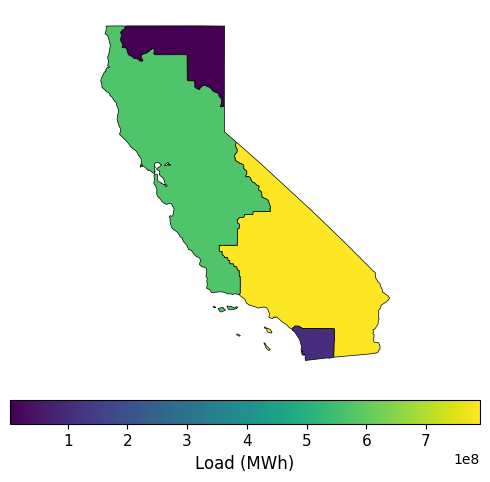

In [256]:
gdf_loads = loads_shape.join(loads_p)
legend_kwargs = {"label":"Load (MWh)", "orientation":"horizontal", "pad":0.05}
fig, _ = plot_map(gdf_loads, "Load", legend_kwargs)

fig.savefig(Path(FIGURES, "cali_load.png"))

# Solar Capacity Heatmap

In [257]:
solar_shape = gpd.read_file(Path(SHAPES_DIR, "regions_onshore_s70.geojson")).set_index("name")
solar_shape.head()

,geometry
name,
p101 0,"POLYGON ((-119.62229 35.17917, -119.65682 35.1..."
p101 1,"POLYGON ((-118.02899 33.67789, -118.02485 33.6..."
p101 10,"POLYGON ((-117.30026 37.06435, -118.03244 36.8..."
p101 11,"POLYGON ((-118.86897 34.53808, -118.97497 34.6..."
p101 12,"POLYGON ((-119.53231 36.18649, -119.52944 36.2..."


In [258]:
solar_gens = n.generators[n.generators.carrier == "solar"]
gens_t = n.generators_t["p_max_pu"]
gens = gens_t[[x for x in solar_gens.index if x in gens_t]]
name_mapper = {x:x.split(" solar")[0] for x in gens}
gens = gens.rename(columns=name_mapper)
gens = gens.T.groupby(level=0).mean().T.mean().to_frame(name="Capacity Factor")
gens.index.name = "name"
gens.head()

,Capacity Factor
name,
p101 0,0.213024
p101 1,0.206085
p101 10,0.231599
p101 11,0.219805
p101 12,0.202904


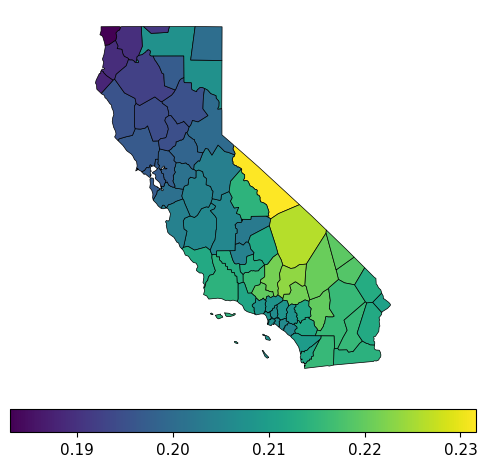

In [259]:
gdf_solar = solar_shape.join(gens)
legend_kwargs = {"label":"", "orientation":"horizontal", "pad":0.05}
fig, _ = plot_map(gdf_solar, "Capacity Factor", legend_kwargs)

fig.savefig(Path(FIGURES, "cali_solar.png"))

# Wind Capacity Heatmap

In [260]:
wind_shape_onshore = gpd.read_file(Path(SHAPES_DIR, "regions_onshore_s70.geojson")).set_index("name")
wind_shape_offshore = gpd.read_file(Path(SHAPES_DIR, "regions_offshore_s70.geojson")).set_index("name")

In [261]:
onshore_gens = n.generators[n.generators.carrier == "onwind"]
onshore_gens_t = n.generators_t["p_max_pu"]
on_gens = onshore_gens_t[[x for x in onshore_gens.index if x in onshore_gens_t]]
name_mapper = {x:x.split(" onwind")[0] for x in on_gens}
on_gens = on_gens.rename(columns=name_mapper)
on_gens = on_gens.T.groupby(level=0).mean().T.mean().to_frame(name="Capacity Factor")
on_gens.index.name = "name"
on_gens.head()

,Capacity Factor
name,
p101 0,0.016897
p101 1,0.024289
p101 10,0.015058
p101 11,0.038069
p101 12,0.017620


In [262]:
offshore_gens = n.generators[n.generators.carrier == "offwind_floating"]
offshore_gens_t = n.generators_t["p_max_pu"]
off_gens = offshore_gens_t[[x for x in offshore_gens.index if x in offshore_gens_t]]
name_mapper = {x:x.split(" offwind")[0] for x in off_gens}
off_gens = off_gens.rename(columns=name_mapper)
off_gens = off_gens.T.groupby(level=0).mean().T.mean().to_frame(name="Capacity Factor")
off_gens.index.name = "name"
off_gens.head()

,Capacity Factor
name,
p90 0,0.519264
p91 10,0.488700
p91 21,0.537616
p91 7,0.526254
p92 0,0.567566


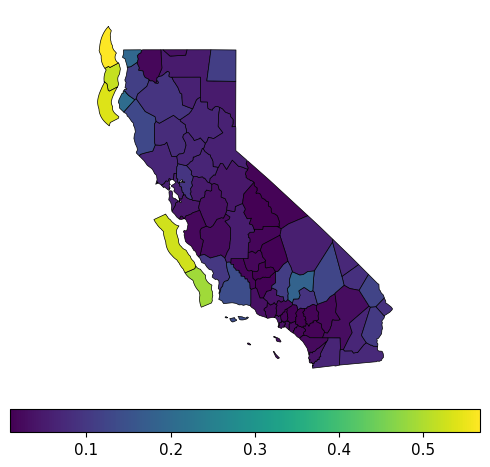

In [263]:
gdf_onwind = wind_shape_onshore.join(on_gens)
gdf_offwind = wind_shape_offshore.join(off_gens)
gdf = pd.concat([gdf_onwind, gdf_offwind])

legend_kwargs = {"label":"", "orientation":"horizontal", "pad":0.05}
fig, _ = plot_map(gdf, "Capacity Factor", legend_kwargs)
fig.savefig(Path(FIGURES, "cali_wind.png"))